# Прогнозирование оттока клиентов телеком компании

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники будут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Стоит задача обучить на этих данных модель для прогноза оттока клиентов.

**План работы**

**Шаг 1. Загрузка данных**

Загрузить данные и выполнить их первичный осмотр.

**Шаг 2. Объединение данных**

Объединить признаки в один датафрейм по ключу.

**Шаг 3. Исследовательский анализ и предобработка данных объединённого датафрейма**

Выполнить исследовательский анализ объединённого датафрейма, визуализировать распределения признаков и при необходимости выполните предобработку. Провести корреляционный анализ.

**Шаг 4. Подготовка данных**

Выполнить подготовку данных для обучения модели, разделите данные на выборки.

**Шаг 5. Обучение моделей машинного обучения**

Обучить модели и подберать гиперпараметры.

**Шаг 6. Выбор лучшей модели**

Выберать лучшую модель и проверить её качество на тестовой выборке.

**Шаг 7. Общий вывод и рекомендации заказчику**

Сделать общий вывод о проделанной работе: описать основные этапы работы, полученные результаты и рекомендации для бизнеса.

## Загрузка данных

Загрузим датасеты и изучим данные

In [ ]:
!pip install phik

In [ ]:
#загрузим требуемые библиотеки
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
from datetime import datetime
from phik.report import plot_correlation_matrix
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             roc_curve,
                             roc_auc_score)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostClassifier

#настройки
warnings.filterwarnings("ignore")

#константы
RANDOM_STATE = 301023

In [ ]:
#откроем и сохраним датафреймы

contract = pd.read_csv('/datasets/contract_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

Создадим функцию, которая будет выводить информацию о датафрейме и 5 случайных строк из него

In [ ]:
def get_df_info(df):
    display(df.sample(5))
    display(df.info())

Применим функцию к нашим датафреймам.

In [ ]:
get_df_info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1072,7771-ZONAT,2018-04-01,No,Two year,No,Bank transfer (automatic),56.75,1248.5
60,0434-CSFON,2016-03-01,No,Month-to-month,Yes,Electronic check,100.50,4723.5
2364,4559-UWIHT,2018-12-01,No,Month-to-month,Yes,Electronic check,82.65,1157.1
4482,6711-FLDFB,2019-04-01,No,Month-to-month,Yes,Electronic check,74.90,749.0
6029,9714-EDSUC,2019-10-01,No,Month-to-month,Yes,Mailed check,94.90,406.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Датафрейм contract содержит информацию о договорах. Содержит 7043 строк и 7 столбцов.

In [ ]:
get_df_info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1012,1004-NOZNR,Fiber optic,Yes,No,No,No,Yes,Yes
4208,5320-BRKGK,DSL,Yes,No,Yes,Yes,Yes,No
3664,0129-KPTWJ,Fiber optic,No,No,Yes,No,Yes,Yes
4112,9591-YVTEB,DSL,Yes,Yes,No,No,Yes,No
3221,5208-FVQKB,DSL,Yes,Yes,No,Yes,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Датафрейм internet содержит информацию о интернет-услугах. Содержит 5517 строк и 7 столбцов.  

In [ ]:
get_df_info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
3566,9677-AVKED,Female,0,No,Yes
2575,5186-PEIZU,Female,0,No,No
5404,8910-ICHIU,Female,0,No,No
3718,8468-EHYJA,Female,0,Yes,No
2262,4529-CKBCL,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Датафрейм personal содержит информацию о персональных данных клиента. Содержит 7043 строк и 4 столбца.  

In [ ]:
get_df_info(phone)

,customerID,MultipleLines
1575,8345-MVDYC,No
2511,1179-INLAT,No
2592,7299-GNVPL,No
2909,6772-WFQRD,No
3726,3345-PBBFH,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Датафрейм phone содержит информацию об услугах телефонии. Содержит 6361 строку и 2 столбца.  

### Вывод 1


В датафреймах personal и contract содержатся равное количество строк, можно предположить, что каждый из клиентов заключил договор с компанией, часть из них контракт разорвали. В столбце EndDate у таких клиентов стоит дата окончания договора.

В таблицах phone и internet содержится разное количество строк. Можно сделать вывод что часть клиентов пользуется только одним видом услуг, а часть и телефонией и интернетом.


## Объединение данных

Объединим датафреймы в одину таблицу, учтем что в датафреймах internet и phone строк меньше, чем двух других. Соединить таблицы можно по столбцу customerID. Используем метод merge() с параметром how = 'outer', это позволит не потерять данные из датафрейма contract и присоединить все данные из других, а при обнаружении недостающих данных на их месте появятся пропуски.


In [ ]:
# последовательно присоединим все датафреймы к contract

df = contract.merge(personal, on='customerID', how='outer')
df = df.merge(internet, on='customerID', how='outer')
df = df.merge(phone, on='customerID', how='outer')

Выведем информацию об объединенном датафрейме

In [ ]:
get_df_info(df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
5003,1867-BDVFH,2018-11-01,No,Month-to-month,Yes,Electronic check,74.35,1159.86,Male,0,Yes,Yes,Fiber optic,No,No,No,No,No,No,Yes
835,4250-WAROZ,2015-02-01,No,Month-to-month,Yes,Electronic check,93.25,5595.0,Male,1,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,Yes,Yes
5680,6982-UQZLY,2019-10-01,No,Month-to-month,Yes,Mailed check,20.85,85.9,Female,1,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4121,0576-WNXXC,2017-09-01,No,Month-to-month,Yes,Electronic check,95.55,2881.79,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,No,Yes,Yes
425,2055-SIFSS,2015-07-01,2018-06-01,Month-to-month,No,Bank transfer (automatic),51.65,1843.9,Female,1,Yes,No,DSL,No,No,No,No,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None

Объединение произошло так, как планировалось. Все столбцы присутствуют, в столбцах присоединенных из датафреймов  internet и phone появились пропуски.

## Исследовательский анализ и предобработка данных

### Предобработка данных

Проверим датафрейм на дубликаты и пропуски.

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Дубликатов не обнаружено.

Заменим пропуски в столбцах на значение "No", исходя из предположения, что клиенты у которых образовались пропуски не пользуются услугами интернета или телефонии.

Для столбца MultipleLines используем в качестве замены пропусков значение "Not phone", так мы отобразим категорию пользователей только интернет-услугами компании.

In [ ]:
df['MultipleLines'].fillna('Not phone', inplace=True)

In [ ]:
df.fillna('No', inplace=True)

In [ ]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

#### Создание целевого признака

Для дальнейшей работы и обучения моделей сразу создадим целевой признак. В качестве основы возьмем столбец EndDate. Где значение "No" будет соответствовать 0, а наличие даты - 1.

In [ ]:
# создадим функцию, которая берет значения из столбца EndDate
# и на их основе возвращает либо 0, либо 1

def create_target(row):
    value = row['EndDate']
    if value == 'No':
        return 0
    else:
        return 1

Применим функцию к датафрейму, и создадим новый столбец

In [ ]:
df['target'] = df.apply(create_target, axis=1)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,Not phone,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,Not phone,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


Новый столбец  появился в таблице

#### Изменение типов данных

Преобразуем данные в столбцах с датой в формат datetime64. В столбце EndDate по мимо даты содержится значение "No". Заменим его на дату выгрузки данных 01 февраля 2020.

In [ ]:
# заменим значения методом .replace()
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01', regex=True)

Теперь оба столбца с датой переведем в формат datetime.

In [ ]:
df['BeginDate']= pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['EndDate']= pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

В столбце TotalCharges содержаться данные о тратах клиентов за все время с момента заключения договора. И как мы видим из таблицы имеют вид цифр, но тип данных у столбца object. Заменим тип данных на числовой.

In [ ]:
# используем параметр errors='coerce' у метода to_numeric
# заменив некорректные данные на Nan

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Проверим данные на пропуски после преобразования

In [ ]:
df['TotalCharges'].isna().sum()

11

Выведем строки с пропущенными значениями в столбце "TotalCharges"

In [ ]:
df[df.isna().any(axis=1)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Not phone,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Not phone,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,...,Yes,No,No,No,No,No,No,No,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


По таблице видно, что даты начала действия договора и выгрузки совпали, по видимому это новые клиенты только заключившие договор и данные в таблицуне заносили

Заменим получившиеся пропуски на 0.

In [ ]:
df['TotalCharges'].fillna(0, inplace=True)

Выгрузим еще раз данные по датафрейму.

In [ ]:
get_df_info(df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
5272,8780-IXSTS,2019-05-01,2020-02-01,Month-to-month,Yes,Electronic check,90.10,891.99,Female,0,...,No,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
1893,3466-WAESX,2018-10-01,2020-02-01,Month-to-month,Yes,Electronic check,69.10,1127.71,Male,0,...,Yes,DSL,Yes,Yes,No,No,No,Yes,Yes,0
2527,8931-GJJIQ,2019-01-01,2020-02-01,Month-to-month,Yes,Electronic check,83.30,1082.90,Female,0,...,No,Fiber optic,No,No,No,No,No,Yes,Yes,0
852,8713-IGZSO,2019-12-01,2020-02-01,Month-to-month,No,Mailed check,24.85,51.69,Male,0,...,No,No,No,No,No,No,No,No,Yes,0
6869,5906-CVLHP,2016-04-01,2020-02-01,One year,Yes,Credit card (automatic),54.15,2490.90,Female,0,...,Yes,DSL,No,Yes,No,Yes,No,No,No,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

None

#### Вывод

На этапе предобработки данных мы проверили датафрейм по дубликаты и пропуски, изменили тип данных в столбцах  BeginDate, EndDate и TotalCharges.

Создали столбец с целевым признаком на основе даты окончания действия договора.


### Исследовательский анализ данных

Выведем статистики для числовых столбцов датафрейма

In [ ]:
df.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,target
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.162147,0.156325
std,30.090047,2112.742814,0.368612,0.363189
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,0.000000
50%,70.350000,1343.350000,0.000000,0.000000
75%,89.850000,3236.690000,0.000000,0.000000
max,118.750000,9221.380000,1.000000,1.000000


Отстортируем также отдельно действующих и ушедший клиентов

In [ ]:
go_clients = df.query('target ==1')

In [ ]:
stay_clients = df.query('target == 0')

Выведем статистики для этих категорий

In [ ]:
stay_clients.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,target
count,5942.000000,5942.000000,5942.000000,5942.0
mean,62.763455,2067.866420,0.153147,0.0
std,29.844462,2193.898483,0.360160,0.0
min,18.250000,0.000000,0.000000,0.0
25%,30.062500,374.352500,0.000000,0.0
50%,69.200000,1192.800000,0.000000,0.0
75%,87.237500,3173.837500,0.000000,0.0
max,118.600000,9221.380000,1.000000,0.0


In [ ]:
go_clients.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,target
count,1101.000000,1101.000000,1101.000000,1101.0
mean,75.546004,2371.377275,0.210718,1.0
std,29.116213,1581.862275,0.408003,0.0
min,18.400000,77.840000,0.000000,1.0
25%,56.150000,1048.050000,0.000000,1.0
50%,84.200000,2139.030000,0.000000,1.0
75%,99.500000,3404.910000,0.000000,1.0
max,118.750000,7649.760000,1.000000,1.0


Изучим распределение расходов за месяц для всех абонентов, действующих и ушедших.

Построим гистограмму распределения расходов за месяц для каждого клиента

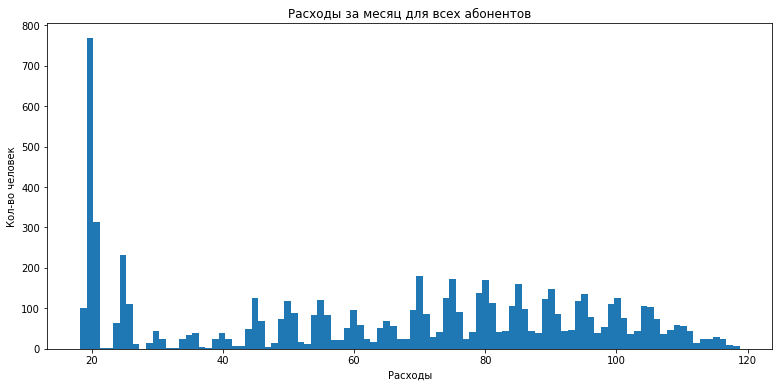

In [ ]:
plt.figure(figsize=[13,6])
plt.hist(df['MonthlyCharges'], bins=100)
plt.title('Расходы за месяц для всех абонентов')
plt.xlabel('Расходы')
plt.ylabel('Кол-во человек');

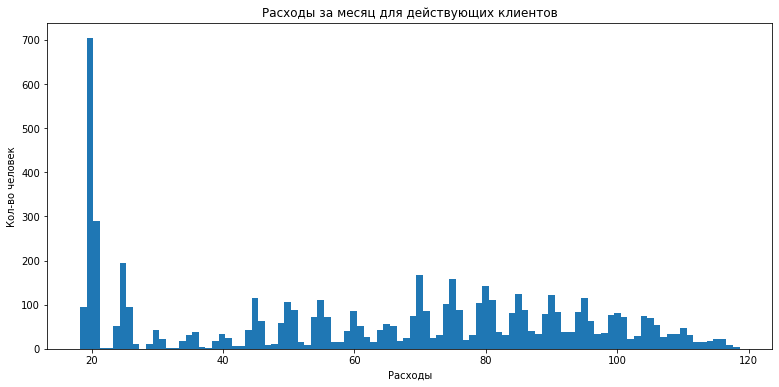

In [ ]:
plt.figure(figsize=[13,6])
plt.hist(stay_clients['MonthlyCharges'], bins=100)
plt.title('Расходы за месяц для действующих клиентов')
plt.xlabel('Расходы')
plt.ylabel('Кол-во человек');

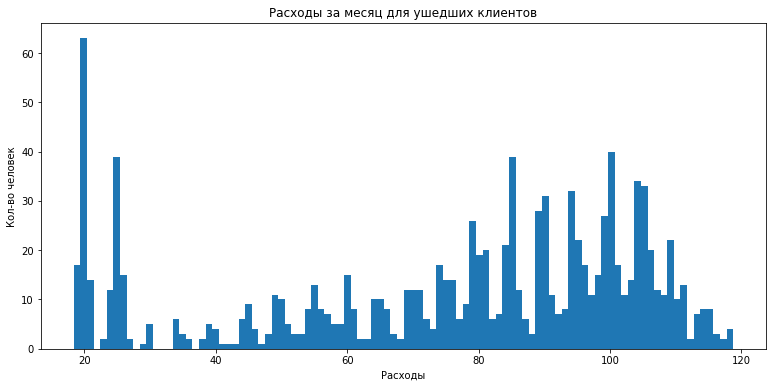

In [ ]:
plt.figure(figsize=[13,6])
plt.hist(go_clients['MonthlyCharges'], bins=100)
plt.title('Расходы за месяц для ушедших клиентов')
plt.xlabel('Расходы')
plt.ylabel('Кол-во человек');

Исходя из распределений, можно сделать вывод, что большая часть клиентов платят за месяц около 20. Далее число пользователей с разным порогом трат примерно одинаково. Однако среди ушедших клиентов больше доля тех клиентов, которые платили от 80-110.

Также видно что "средний чек", то есть среднее значение и медиана трат в месяц у ушедших клиентов выше чем у действующих.

Изучим распределение общих трат для всех абонентов, действующих и ушедших.

Построим гистограмму распределения расходов для каждого абонента.

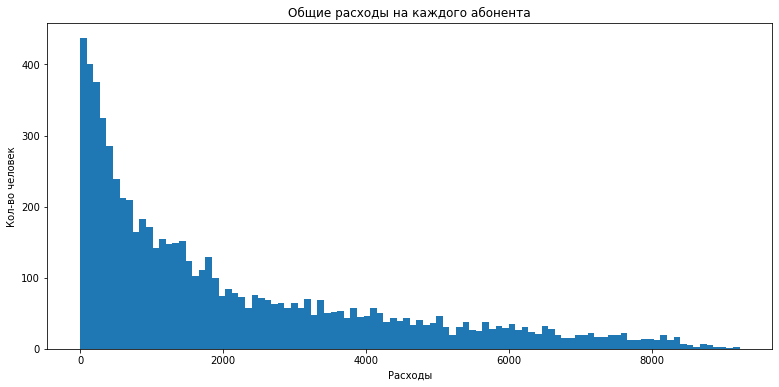

In [ ]:
plt.figure(figsize=[13,6])
plt.hist(df['TotalCharges'], bins=100)
plt.title('Общие расходы на каждого абонента')
plt.xlabel('Расходы')
plt.ylabel('Кол-во человек');

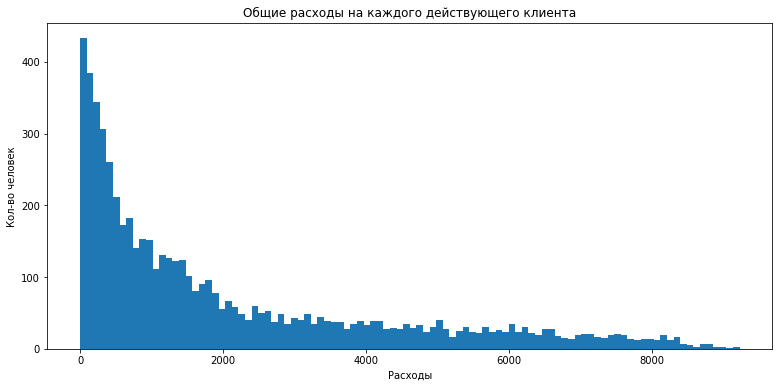

In [ ]:
plt.figure(figsize=[13,6])
plt.hist(stay_clients['TotalCharges'], bins=100)
plt.title('Общие расходы на каждого действующего клиента')
plt.xlabel('Расходы')
plt.ylabel('Кол-во человек');

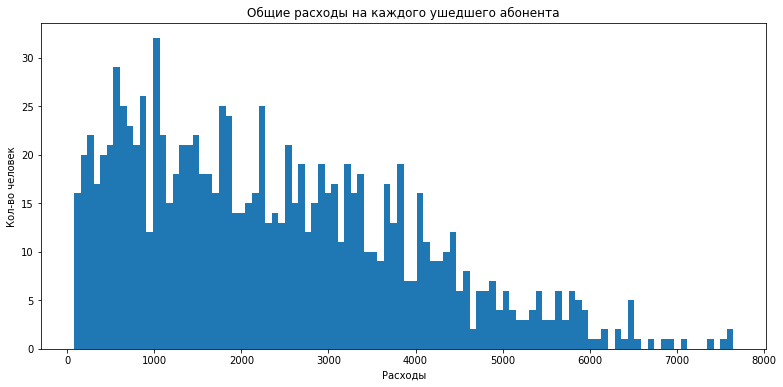

In [ ]:
plt.figure(figsize=[13,6])
plt.hist(go_clients['TotalCharges'], bins=100)
plt.title('Общие расходы на каждого ушедшего абонента')
plt.xlabel('Расходы')
plt.ylabel('Кол-во человек');

Исходя из распределений, можно сделать вывод, что большая часть клиентов потратила на услуги компании до 2000. Далее число пользователей в разным порогом трат постепенноно снижается.
Среднее значение и медиана трат у ушедших клиентов выше чем у действующих, а также доля клиентов с расходами свыше 2000 тоже больше.

Исследуем столбцы с категориальными признаками для всех клиентов, действующих и ушедших.

In [ ]:
# создадим функцию, которая на вход принимает датафреймы
# и название требуемого с толбца,
# а возвращей круговые диаграммы для столбца для
# каждого вида абонентов

def make_pie(df, go_clients, stay_clients, column):
    pie_df = df.groupby(column)[column].count()
    pie_go_clients = go_clients.groupby(column)[column].count()
    pie_stay_clients = stay_clients.groupby(column)[column].count()

    labels = df[column].unique()

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

    ax1.pie(pie_df, autopct='%1.1f%%')
    ax2.pie(pie_stay_clients, autopct='%1.1f%%')
    ax3.pie(pie_go_clients, autopct='%1.1f%%')

    ax1.set_title('Все клиенты')
    ax2.set_title('Действующие клиенты')
    ax3.set_title('Ушедшие клиенты')

    fig.legend(labels=labels)
    fig.suptitle('Соотношение категорий для столбца {0}'.format(column))
    plt.show();

*Столбец Type, тип оплаты: раз в год-два или ежемесячно.*

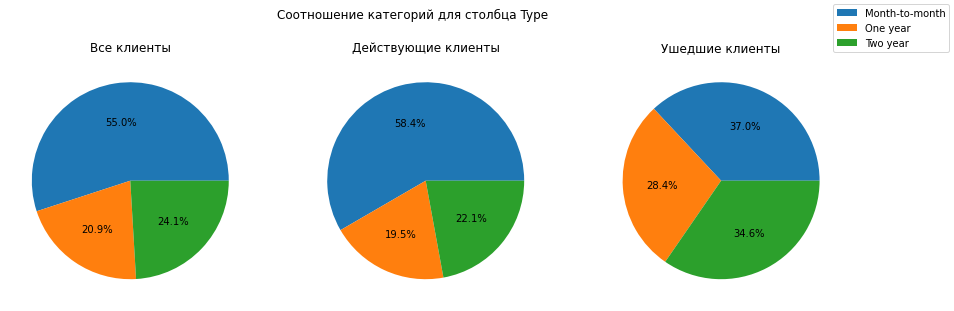

In [ ]:
make_pie(df, go_clients, stay_clients, 'Type')

Большая часть действующих клиентов платит ежемесячно. Среди ушедших клиентов доля типов оплаты близки по значению, много клиентов с оплатой за год или два.

*Столбец PaperlessBilling, электронный расчётный лист.*

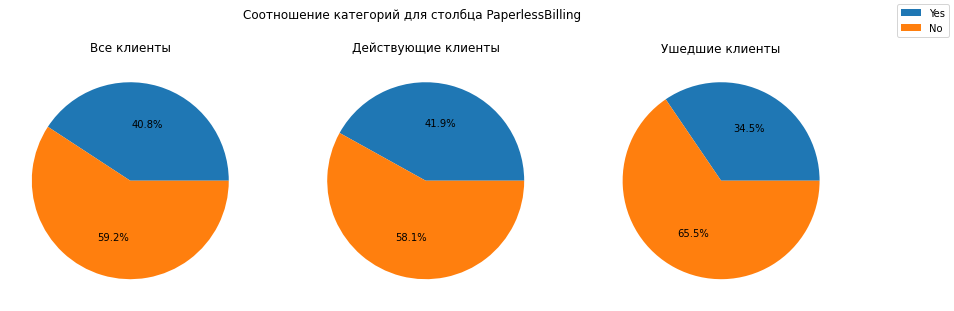

In [ ]:
make_pie(df, go_clients, stay_clients, 'PaperlessBilling')

Большая часть клиентов не пользуется этой услугой, среди ушедших клиентов доля их выше.

*Столбец PaymentMethod, тип платежа.*

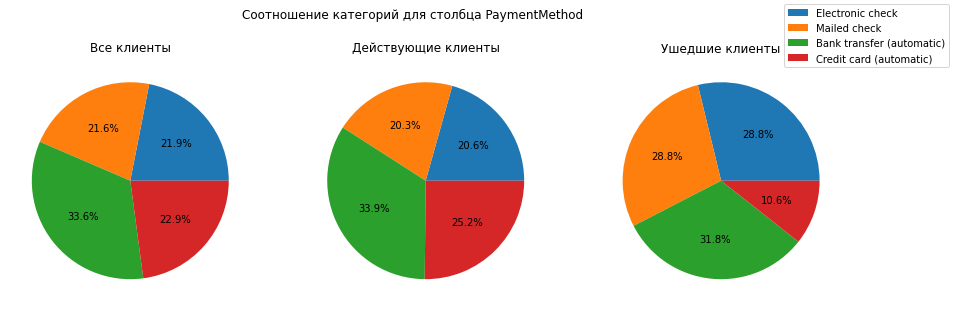

In [ ]:
make_pie(df, go_clients, stay_clients, 'PaymentMethod')

Большинство клиентов используют для оплаты банковские переводы, остальные виды оплаты используются в равной степени. Среди ушедших клиентов минимальна доля оплаты кредитной картой.

*Столбец gender, пол.*

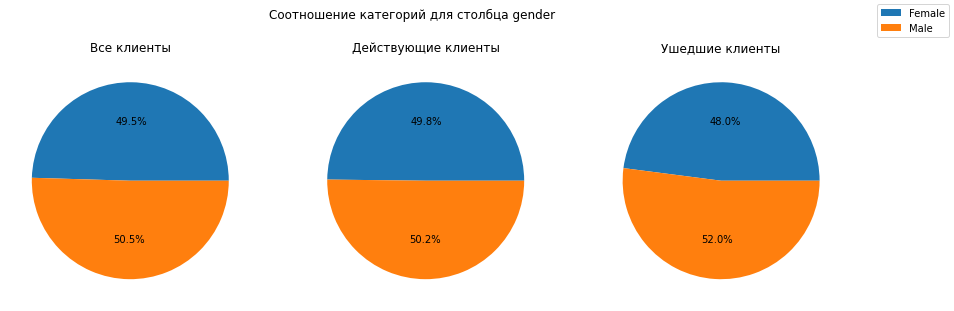

In [ ]:
make_pie(df, go_clients, stay_clients, 'gender')

Пользователей обоего пола примерно одинаковое количество для всех клиентов.

*Столбец SeniorCitizen, является ли абонент пенсионером.*

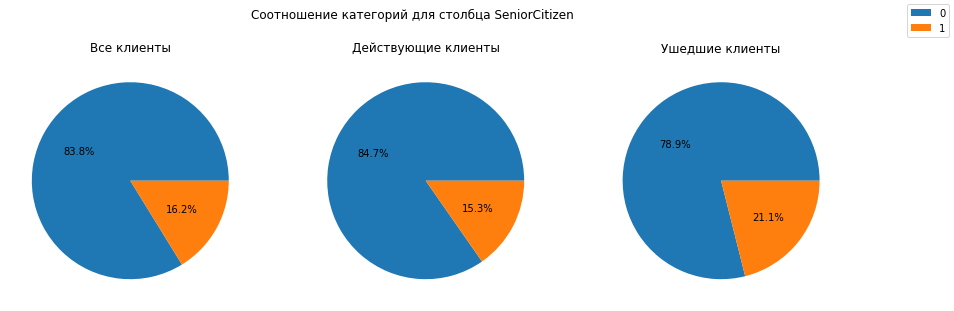

In [ ]:
make_pie(df, go_clients, stay_clients, 'SeniorCitizen')

Среди действующих абонентов пенсионеров 15,3%, а среди ушедших их доля выше и составляет 21.1%.

*Столбец Partner,  есть ли у абонента супруг или супруга.*

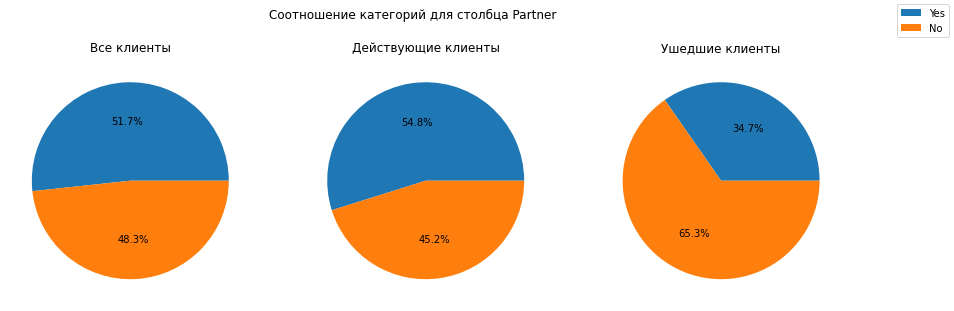

In [ ]:
make_pie(df, go_clients, stay_clients, 'Partner')

Среди действующих клиентов доля одиноких составляет 45,2%, а среди ушедших 65,3%.

*Столбец Dependents, есть ли у абонента дети.*

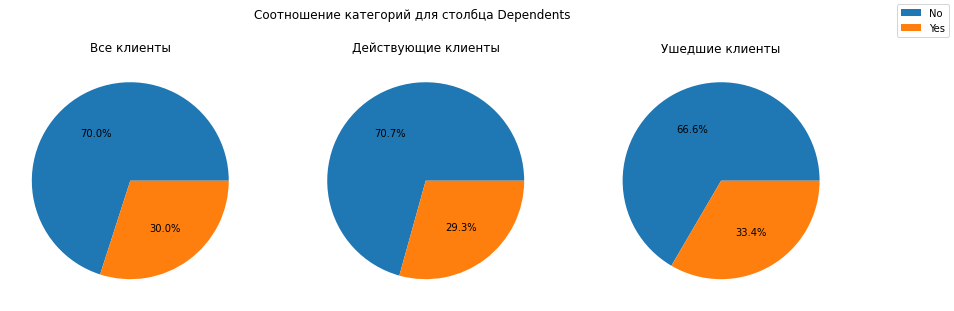

In [ ]:
make_pie(df, go_clients, stay_clients, 'Dependents')

Доля клиентов с детьми во всех категориях отличается не значительно.

*Столбец, InternetService, тип подключения.*

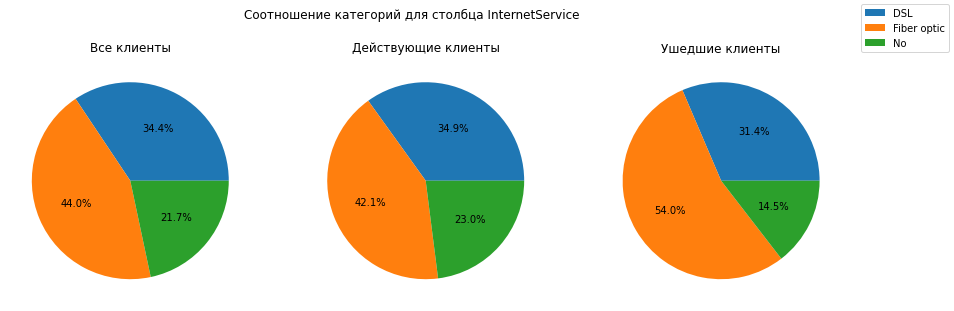

In [ ]:
make_pie(df, go_clients, stay_clients, 'InternetService')

Среди ушедших доля клиентов не использующих интернет ниже чем среди действующих, большинство из них использовало оптическое волокно для подключения к интернету.

*Столбцы OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies - интернет-услуги*

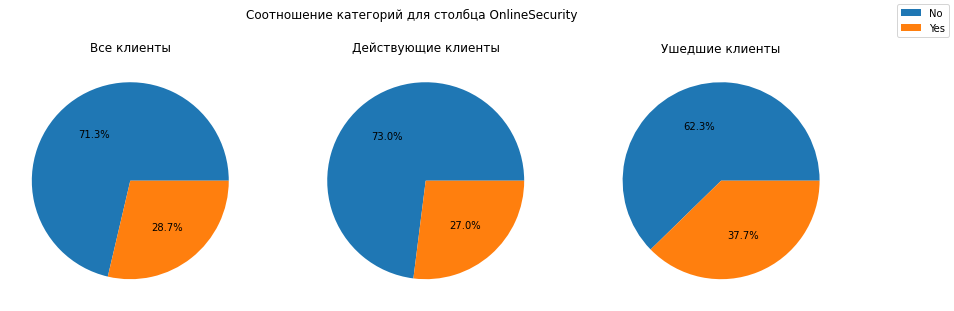

In [ ]:
make_pie(df, go_clients, stay_clients, 'OnlineSecurity')

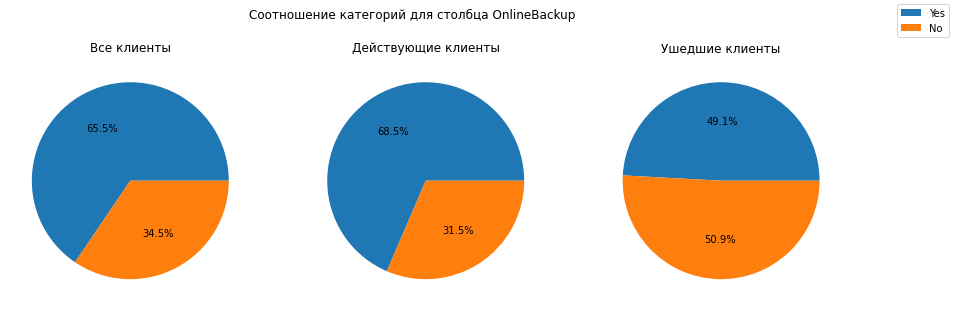

In [ ]:
make_pie(df, go_clients, stay_clients, 'OnlineBackup')

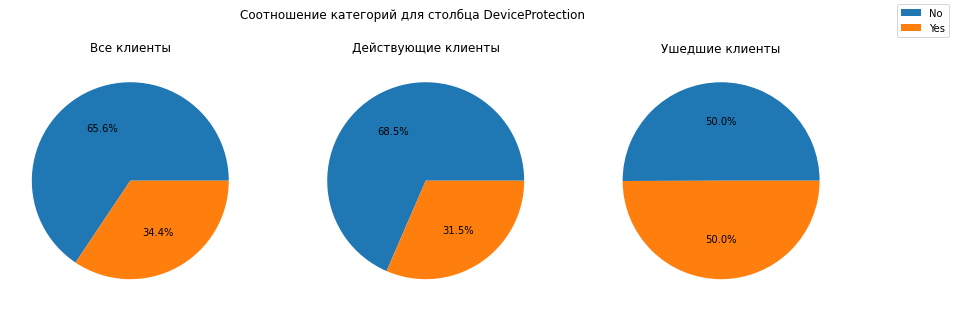

In [ ]:
make_pie(df, go_clients, stay_clients, 'DeviceProtection')

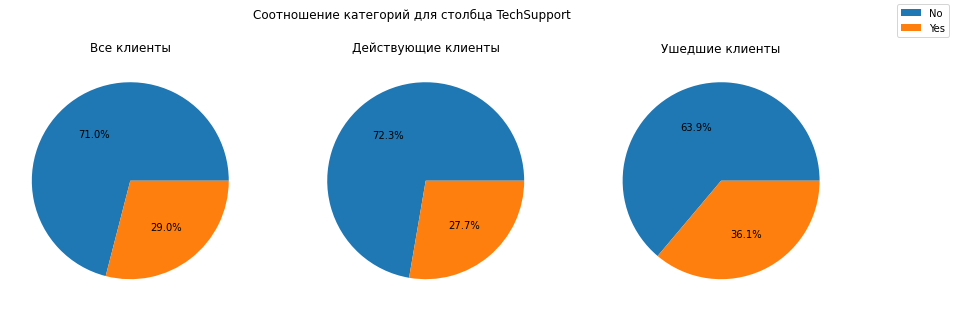

In [ ]:
make_pie(df, go_clients, stay_clients, 'TechSupport')

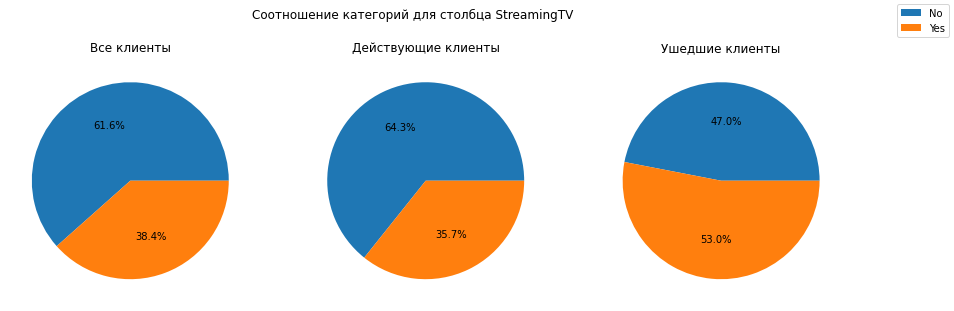

In [ ]:
make_pie(df, go_clients, stay_clients, 'StreamingTV')

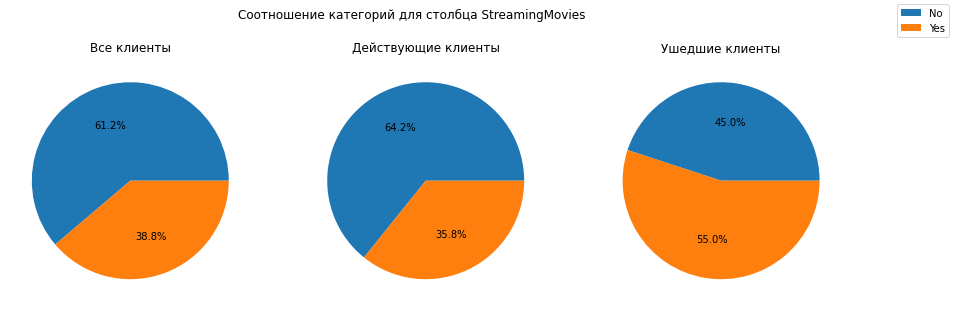

In [ ]:
make_pie(df, go_clients, stay_clients, 'StreamingMovies')

Для всех видов интернет-услуг заметна закономерность. Среди ушедших клиентов доля пользователей у которых услуги были подключены, выше чем у действущих.

*Столбец MultipleLines, подключение телефона к нескольким линиям одновременно.*

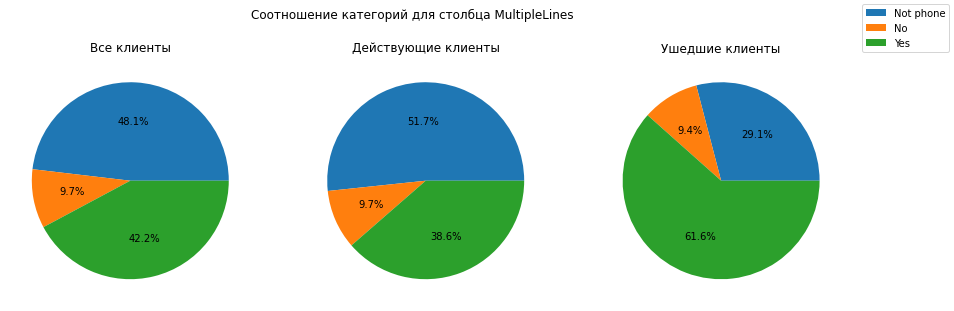

In [ ]:
make_pie(df, go_clients, stay_clients, 'MultipleLines')

Среди ушедших клиентов доля использовавших подключение телефона к нескольким линиям одновременно, заметно выше чем среди действующих.

#### Вывод

Большая часть клиентов платят за месяц около 20, среди ушедших клиентов больше доля тех клиентов, которые платили от 80-110.

Среднее значение и медиана трат в месяц у ушедших клиентов выше чем у действующих.

Большая часть клиентов потратила на услуги компании до 2000.

Среднее значение и медиана трат у ушедших клиентов выше чем у действующих.

Большая часть действующих клиентов платит ежемесячно.

Большинство клиентов используют для оплаты банковские переводы, остальные виды оплаты используются в равной степени. Среди ушедших клиентов минимальна доля оплаты кредитной картой.

Среди действующих абонентов пенсионеров 15,3%, а среди ушедших их доля выше и составляет 21.1%.

Среди действующих клиентов доля одиноких составляет 45,2%, а среди ушедших 65,3%

Среди ушедших доля клиентов не использующих интернет ниже чем среди действующих.

Среди ушедших клиентов доля пользователей у которых услуги были подключены, выше чем у действущих.

Среди ушедших клиентов доля использовавших подключение телефона к нескольким линиям одновременно, выше чем среди действующих.


### Дисбаланс классов

Проверим целевой признак на дисбаланс классов.

Выведем отношение действующих и ушедших клиентов в процентах

In [ ]:
df['target'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: target, dtype: float64

Визуализируем с помощью графика.

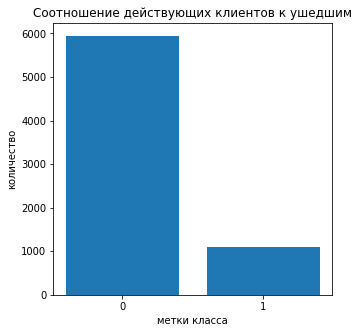

In [ ]:
y = df['target'].value_counts()
x = y.index
plt.figure(figsize=[5,5])
plt.bar(x, y)
plt.xlabel('метки класса')
plt.xticks(x)
plt.ylabel('количество')
plt.title('Соотношение действующих клиентов к ушедшим')
plt.show()

От общего количества абонентов, доля ушедших клиентов составляет 15,63%. Видим наличие дисбаланса положительного и отрицательного классов.

### Корреляция признаков

Проверим на корреляцию все признаки.

Используем библиотеку phik, она позволяет выявить корреляцию среди как числовых, так и категориальных данных.

In [ ]:
# построим матрицу корреляции
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'target']


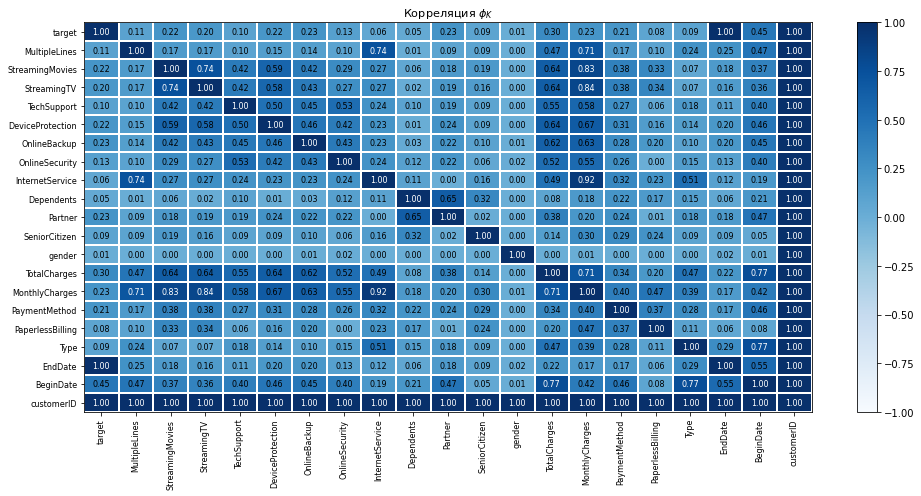

In [ ]:
# визуализируем её
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        vmin=-1, vmax=1, color_map='Blues', title=r'Корреляция $\phi_K$', fontsize_factor=0.8,
                        figsize=(14,7))
plt.tight_layout()

Из матрицы корреляции видно:
- столбец target имеет 1,00  корреляцию со столбцом EndDate
- столбец customerID имеет корреляцию 1,00 со всеми остальными
- столбец gender не имеет корреляции со всеми признаками, включая целевой
- столбец MonthlyCharges имеет корреляцию более 0,5 с 9 признаками

Считаю целесообразным удалить данные столбцы из признаков при обучении модели, увеличив качество модели.

### Вывод

На этапе предобработки данных датафрейм был проверен на дубликаты и пропуски.

Изменили тип данных в столбцах: BeginDate, EndDate, TotalCharges.

Создали столбец с целевым признаком на основе даты окончания действия договора.

Выявлены следующие закономерности в данных для ушедших клиентов:

- больше доля клиентов, платящих от 80-110
- среднее значение и медиана трат в месяц выше
- среднее значение и медиана общих трат выше
- минимальна доля оплаты кредитной картой
- доля абонентов пенсионеров выше и составляет 21.1%
- доля одиноких составляет 65,3%
- доля клиентов не использующих интернет ниже
- доля пользователей у которых услуги были подключены выше
- доля использовавших подключение телефона к нескольким линиям одновременно выше

От общего количества абонентов, доля ушедших клиентов составляет 15,63%.

Видим наличие дисбаланса положительного и отрицательного класса.



## Подготовка признаков

Подготовим признаки для обучения моделей.

Создадим дополнительный признак, который будет хранить информацию о количестве дней прошедших с момента заключения договора до его окончания или до дня выгрузки данных.

In [ ]:
# создадим фуккцию, коорая считает разницу в днях
# между столбцами BeginDate и EndDate

def total_days(row):
    end = row['EndDate']
    begin = row['BeginDate']
    days_count = (end - begin).days
    return days_count

In [ ]:
# применим функцию и создадим новый столбец

df['total_days'] = df.apply(total_days, axis=1)

# выведем датафрейм на экран

df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,total_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,Not phone,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,Not phone,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


Создадим признаки и целевой признак.

Удалим из признаков следующие столбцы:
- BeginDate и EndDate так как на основе этих столбцов создали целевой призак, наличие их приведек к утечке
- customerID идентификатор, уникальный для каждого пользователя и не требуется для обучения
- target целевой признак
- gender как выявили при анализе корреляции признак не влияет на целевую переменную
- MonthlyCharges имеет корреляцию сразу с несколькими столбцами.

In [ ]:
features = df.drop(['BeginDate', 'EndDate', 'target', 'gender', 'customerID', 'MonthlyCharges'], axis=1)
target = df['target']

Разделим датафрейм на обучающую и тестовую выборки

In [ ]:
# используем параметр stratify для сохранения изначального соотношения классов

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                              target,
                                                                              test_size=0.25,
                                                                              stratify= target,
                                                                              random_state= RANDOM_STATE)

Проверим размеры выборок и соотношение классов.

In [ ]:
features_train.shape

(5282, 16)

In [ ]:
features_test.shape

(1761, 16)

In [ ]:
1761/7043

0.25003549623739885

In [ ]:
target_train.value_counts(normalize=True), target_test.value_counts(normalize=True)

(0    0.84362
 1    0.15638
 Name: target, dtype: float64,
 0    0.843839
 1    0.156161
 Name: target, dtype: float64)

Размер выборок соответствует заданным параметрам

Создадим список категориальных признаков

In [ ]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()

## Обучение моделей

Перед нами стоит задача бинарной классификации.

Для обучения выберем три модели.
- DecisionTreeClassifier
- RandomForestClassifier
- CatBoostClassifier

В качестве оценки качества моделей используем метрику ROC-AUC, так как для бизнеса больше важен не сам факт ухода клиента, а скорее вероятность наступления такого события.

Так же важно оценить отношение истинно-положительных и истинно-отрицательных ответов модели к ложно-положительным и ложно-отрицательным.

Большое количество ложно-отрицательных ответов приведет к тому, что компании не удастся сдержать отток клиентов.

Большое количество ложно-положительных ответов к тому, что число предоставленных промокодов будет слишком большим.

### Решающее дерево

In [ ]:
%%time

# используем OneHotEncoder для категориальных признаков

col_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='error'),
    ohe_features), remainder='passthrough')

model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

# создадим pipeline

pipline_tree = make_pipeline(col_transformer, model_tree)

# подбор гиперпараметров модели

param_grid_tree = {
    'decisiontreeclassifier__max_depth': range(2, 15),
    'decisiontreeclassifier__min_samples_split': (2, 3, 4),
    'decisiontreeclassifier__min_samples_leaf': range(1, 4, 1),
    'decisiontreeclassifier__class_weight':['balanced'],
    'decisiontreeclassifier__random_state':[RANDOM_STATE]
}

# используем GridSearchCV для поиска по сетке

grid_tree = GridSearchCV(
    pipline_tree,
    param_grid_tree,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
)

grid_tree.fit(features_train, target_train)

# сохраним лучшие параметры и меткику

grid_tree_best_score = grid_tree.best_score_
grid_tree_best_params = grid_tree.best_params_


print(f'best_score: {grid_tree_best_score}')
print(f'best_params: {grid_tree_best_params}')

best_score: 0.7590114189331834
best_params: {'decisiontreeclassifier__class_weight': 'balanced', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2, 'decisiontreeclassifier__random_state': 301023}
CPU times: user 13.6 s, sys: 13.2 ms, total: 13.6 s
Wall time: 13.6 s


Решающее дерево на кроссвалидации показало результат по метрике ROC-AUC - 75,90%

### Случайный лес

In [ ]:
%%time
# принцип построения кода одинаков с
# предыдущим пунктом

model_forest = RandomForestClassifier(random_state=RANDOM_STATE)

pipline_forest = make_pipeline(col_transformer, model_forest)

param_grid_forest = {
    'randomforestclassifier__n_estimators': range(50, 251, 50),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4),
    'randomforestclassifier__class_weight':['balanced'],
    'randomforestclassifier__random_state':[RANDOM_STATE]
}

grid_forest = GridSearchCV(
    pipline_forest,
    param_grid_forest,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
)

grid_forest.fit(features_train, target_train)

grid_forest_best_score = grid_forest.best_score_
grid_forest_best_params = grid_forest.best_params_

print(f'best_score: {grid_forest_best_score}')
print(f'best_params: {grid_forest_best_params}')

best_score: 0.8136252752437203
best_params: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 301023}
CPU times: user 16min 14s, sys: 4.5 s, total: 16min 18s
Wall time: 16min 19s


Случайный лес на кроссвалидации показал результат по метрике ROC-AUC - 81,36%

### Catboost

Обучим модель CatBoost, кодирование категориальных признаков применять не требуется, так как модель умеет работь с ними на прямую.

In [ ]:
%%time
model_catboost = CatBoostClassifier(random_state=RANDOM_STATE)

parametrs = { 'iterations': range (1000, 3000, 50),
              'depth': range (1,13, 2),
              'learning_rate': [0.15],
              'auto_class_weights': ['Balanced'],
              'random_state':[RANDOM_STATE]}

grid_cat = GridSearchCV(model_catboost, parametrs, cv=3,scoring='roc_auc')

grid_cat.fit(features_train, target_train, cat_features = ohe_features, verbose = False)

grid_cat_best_score = grid_cat.best_score_
grid_cat_best_params = grid_cat.best_params_
print(f'best_score: {grid_cat_best_score}')
print(f'best_params: {grid_cat_best_params}')

best_score: 0.9070354962220897
best_params: {'auto_class_weights': 'Balanced', 'depth': 3, 'iterations': 1900, 'learning_rate': 0.15, 'random_state': 301023}
CPU times: user 5h 19min 46s, sys: 19min 21s, total: 5h 39min 8s
Wall time: 5h 58min 48s


Catboost на кроссвалидации показал результат по метрике ROC-AUC - 90,70%

## Выбор лучшей модели

### Оценка качества модели

Из всех моделей лучшее качество показала модель Catboost.

Проверим ее на тестовой выборке.

In [ ]:
probabilities_test = grid_cat.best_estimator_.predict_proba(features_test)[:,1]
roc_auc_score(target_test, probabilities_test)

0.9379358864554019

Метрика ROC-AUC для тестовой выборке составила - 93.79%

Дополнительно рассчитаем точность модели, метрику accuracy.

In [ ]:
predict_test = grid_cat.best_estimator_.predict(features_test)
accuracy_score(target_test, predict_test)

0.9068710959681999

Доля правильных ответов для модели составила 90,68%

Построим ROC-кривую для лучшей модели

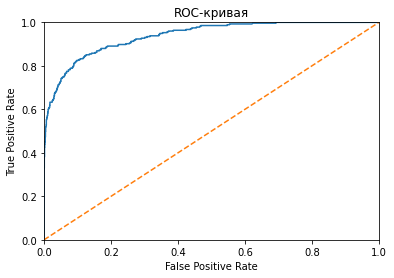

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

Из графика видно, что наша кривая расположена достаточно высоко над линией для случайной модели, что говорит о высоком качестве модели.

Метрика AUC-ROC лучше чем у случайной модели, можно считать что у модели хорошая доля истинно положительных ответов и хорошее качество.

In [ ]:
confusion_matrix(target_test, predict_test)

array([[1384,  102],
       [  62,  213]])

Из матрицы видно, что большая часть ответов приходится на True Negative и True Positive. Модель хорошо предсказывает оба класса текстов.

### Оценка важности признаков

Создадим датафрейм из значений важности признаков для обучения модели.

In [ ]:
data = pd.DataFrame({'feature_importance': grid_cat.best_estimator_.feature_importances_,
              'feature_names': features_train.columns}).sort_values(by=['feature_importance'],
                                                       ascending=False)

Создадим список ТОП-10 признаков по важности и визуализируем его.

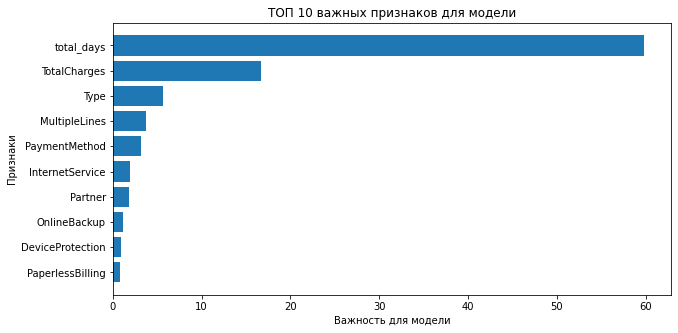

In [ ]:
data = data[:10].sort_values(by=['feature_importance'], ascending=True)
plt.figure(figsize=[10,5])
plt.barh(data['feature_names'], data['feature_importance'])
plt.xlabel('Важность для модели')
plt.ylabel('Признаки')
plt.title('ТОП 10 важных признаков для модели')
plt.show()

Самыми важными признаками являются:
- количество дней пользования услугами компании
- общие расходы абонентов
- тип оплаты: раз в год-два или ежемесячно

## Общий вывод и рекомендации заказчику

Во время выполнения проекта были выполнениы следующие шаги:
- Загрузка данных
- Объединение данных
- Исследовательский анализ и предобработка данных
- Подготовка данных
- Обучение моделей машинного обучения
- Выбор лучшей модели

На этапе **предобработки данных** датафрейм был проверен на дубликаты и пропуски, был создан столбец с целевым признаком на основе даты окончания действия договора.

Выявлены следующие закономерности в данных для ушедших клиентов:

- среднее значение и медиана трат в месяц и общих затрат больше
- минимальна доля оплаты кредитной картой
- доля абонентов пенсионеров выше и составляет 21.1%
- доля одиноких составляет 65,3%
- доля клиентов не использующих интернет ниже
- доля пользователей у которых услуги были подключены выше
- доля использовавших подключение телефона к нескольким линиям одновременно выше
- От общего количества абонентов, доля ушедших клиентов составляет 15,63%.

Было выявлено наличие дисбаланса положительного и отрицательного классов.

Во время **подготовки данных** для обучения создали дополнительный признак, который хранит информацию о количестве дней прошедших с момента заключения договора до его окончания или до дня выгрузки данных.

Удалили признаки, которые не влияют на качество обучения модели или ухудшают качество:
- BeginDate и EndDate так как на основе этих столбцов создали целевой призак, наличие их приведек к утечке
- customerID идентификатор уникальный для каждого пользователя и не требуется для обучения
- target целевой признак
- gender как выявили при анализе корреляции признак не влияет на целевую переменную
- MonthlyCharges имеет корреляцию сразу с несколькими столбцами

В качестве оценки качества моделей использовалась метрика ROC-AUC, так как для бизнеса больше важен не сам факт ухода клиента, а скорее вероятность наступления такого события.


Модель Catboost показала лучшее качество на кросс-валидации.

Её гиперпараметры:
- iterations = 1900,
- depth = 3,
- learning_rate= 0.15,
- auto_class_weights = Balanced

Метрика ROC-AUC для тестовой выборке составила - 93,79%.

Accuracy - доля правильных ответов для модели составила 90,68%.

Метрика AUC-ROC лучше чем у случайной модели, можно считать что у модели хорошая доля истинно положительных ответов и хорошее качество.


При использовании модели для прогнозирования оттока пользователей можно **рекомендовать** обратить внимание на следующие группы абонентов:
- количество дней пользования превышает среднее зачение
- общие и ежемесячные расходы превышают средние значения

При прогнозе возможности ухода для такого клиента, рекоменуется обязательно предоставлять промокод или специальные условия обслуживания.

Если модель не прогноирует уход для данной группы риска, следует предоставить возможность решить целесообразность предоставления промокодов ведущим менеджерам, либо дополнительно проанализировать другие факторы. Такое решение позволит снизить эффект от ложно-отрицательных ответов модели.

Целесообразным будет предоставлять специальные условия всем клиентам, для которых модель прознозирует возможность оттока, так как доля ложно-положительных ответов мала, если сравнивать с вероятностью потерять клиента.

В качестве дополнительной меры профилактики оттока клиентов рекомендуется провести дополнительный анализ предоставляемых компанией услуг, их качество, стоимость и юзабилити. На этапе анализа данных было выявлено, что среди ушедших абонентов, доля пользователей дополнительными услугами выше.

Дополнительно следует уделить внимание следующим аспектам:
- тарификация ежемесячно или ежегодно
- способы оплаты
- возможности предоставления расчетного листа